In [1]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Случайные леса на Титанике

Ахой, дамы и господа! Мы уже знакомились с игрушечными задачками для решения, когда данных было не так много и в них не было особо проблем: ни пропусков, ни строковых значений - все уже готово для модели. В этот раз мы возьмем данные посложнее и посмотрим, как работать с наиболее распространенными случаями предобработки!

В этот раз мы идем в плавание и планируем научиться предсказывать выживет ли человек или нет! В этом нам поможет набор данных с Kaggle - [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic). Вы можете скачать данные прямо с сайта, ну а мы для примеров возьмем уже скачанный файл данных:

In [2]:
URL = 'C:\ml_edu-master\datasets\Titanic_train.csv'
src_df = pd.read_csv(URL)
src_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


На официальном сайте предоставлена информация по данным, сделаем краткое обобщение:
- `Survived` - (Целевая переменная) булевая переменная - выжил или нет;
- `PassengerId` - уникальный идентификатор пассажира; 
- `Pclass` - класс обслуживания;
- `Name` - имя пассажира;
- `Sex` - пол пассажира;
- `Age` - возраст пассажира (вещественное - возраст менее 1; х.5 - призблизительная оценка);
- `SibSp` - количество родственников на борту (братья, сестры, мужья, жены);
- `Parch` - количество родственников на борту (матери, отцы, дочери, сыновья);
- `Ticket` - номер билета;
- `Fare` - плата за проезд;
- `Cabin` - номер кабины;
- `Embarked` - порт посадки.

In [3]:
print(f'Shape of data: {src_df.shape}')
print(src_df.columns)

Shape of data: (891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
src_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Видим 891 запись, 12 колонок: 11 колонок данных и целевая переменная. Как видно из `.info()` - данные имеют пропуск и имеются колонки с типом `object`, что означает наличие строковых (а то и еще каких) данных. Давайте разберемся, как нам сделать базовую предобработку, чтобы построить первую модель!

# Базовый анализ данных

В этой части мы пройдемся по дополнительным методам подготовки данных для построения базовой модели (к тем, что мы изучили ранее). Целью базового анализа является первое знакомство с данными и подготовка к формату, который позволяет модели работать с данными - численная 2D матрица.

## Анализ признаков

При работе с данными первым делом необходимо понять, что значит каждый признак, какие в нем есть значения и пригодится ли он в работе. Для начала самыми подозрительными признаками являются признаки со строчными или целочисленными значениями, которые имеют слишком много уникальных значений. Как правило к категориальным такое отнести уже сложно, поэтому такие признаки чаще всего исключаются. Для примера возьмем признак `PassengerId`. С виду это какой-то индетификацтор, но взглянем на количество уникальных знчений:

In [5]:
print(src_df['PassengerId'].nunique())
print(src_df['PassengerId'].count())
src_df['PassengerId'].head()

891
891


0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

Как видно, абсолютно все значения уникальны, что означает невозможность применения данного признака в работе и он должен быть исключен. Аналогично имеет смысл проверить остальные признаки. Вещественные значения признаков часто также имеют очень много уникальных значений, но их либо сразу относят к типу признаков **непрерывные (численные)**, либо проводят более глубокий анализ.

Полезной практикой является проводить в начале унивариативный анализ, показывающий характеристики каждого признака и что с ним можно/нужно сделать в качестве первого этапа базового анализа.

Для колонок с типом `object` полезно воспользоваться методом `Series.describe()`:

In [6]:
src_df['Name'].describe()

count                            891
unique                           891
top       Jenkin, Mr. Stephen Curnow
freq                               1
Name: Name, dtype: object

**Вывод:** самым первым этапом базового анализа является анализ признаков, который проводится по каждому признаку с целью определить применимость, необходимость коррекции и другие особенности и проблемы.

## Заполнение пропусков

Для просмотра количества пропусков удобно воспользоаться проверкой на `null` и затем вывести сумму по колонкам:

In [7]:
src_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

По результатам отображения количества пропусков видно, что данные имеют пропуски и требуется произвести их обработку, так как данные в таком виде не могут быть применены для построения модели.

Существует огромное количество возможных вариантов работы с пропусками (https://scikit-learn.org/stable/modules/impute.html):
- Исключение признаков (колонок), имеющих пропуски;
- Исключение записей (строк), имеющих пропуски;
- Заполнение пропусков средним/медианным значением признака (**Унивариативное** заполнение - Используется единственный признак);
- Заполнение пропусков наиболее частым значением признака (мода);
- Заполнение путем построения регрессионной модели по остальным признакам (**Мультивариативное** заполнение - используется несколько признаков);
- и т.д.

Так, например, признак `Age` имеет 177 пропущенных значений, что является достаточно большим количеством, чтобы исключить записи с пропусками. Признак также невозможно исключить, так как он имеет информативный характер (возраст часто связывают со способностью к выживанию). Таким образом, можно воспользоваться `sklearn.impute.SimpleImputer` со стратегией заполнения `mean`, чтобы заполнить пропущенные данные на основе статистики остальных данных данного признака.

In [8]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
# Двойные скобки использованы, чтобы передать в fit() 2D массив
X_in = src_df[['Age']]
print(X_in.shape)

src_df['Age'] = imp.fit_transform(X_in)
src_df.isnull().sum()

(891, 1)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Вот так мы убедились в том, что метод работает! Исходя из распределения данных лучше выбирать стратегию по следующему признаку:
- Гауссово распределение - стратегия `mean`, так как в нормальном расрпделении наиболее частое ~ среднее значение;
- Ненормальное распределение - стратегия `meadian`, чтобы получить близкое к наиболее частому значению.

Для категориальных признаков наиболее простым методом является стратегия `most_frequent`, когда берется наиболее частое значение:

In [9]:
imp = SimpleImputer(strategy='most_frequent')
src_df['Embarked'] = imp.fit_transform(src_df[['Embarked']])

src_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Другим методом работы с пропусками является исключение признаков из-за слишком большого количества пропусков:


In [10]:
src_df['Cabin'].isnull().sum()/src_df.shape[0]

0.7710437710437711

77% - это слишком большое количество пропусков, чтобы пытаться заполнить!

## Кодирование признаков

Как уже ранее обсуждалось, признаки бывают разные:
- Непрерывные (численные) - вещественные или целочисленные (чаще всего представляются типом `float` и `int`);
- Категориальные - могут быть представлены строками или числами с небольшим количеством уникальных значений, они могут быть разделены на следующие подтипы:
    - Номинальные - значения признаков ограничены группой возможных значений (красный/синий/зеленый);
    - Бинарные - те же номинальные, но всего две группы (Да/Нет, Правда/Ложь);
    - Последовательные - те же номинальные, но еще группы имеют порядок (плохой/хороший/отличный).

Непрерывные признаки с точки зрения базового анализа не требуют особой предобработки, так как они уже представлены числами. Можно лишь попробовать провести их стандартизацию.

С категориальными часто бывает чуть сложнее. Наибольшую проблему составляют признаки, которые представлены строками, например признак `Embarked`:

In [11]:
src_df.info()
src_df['Embarked'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


S    646
C    168
Q     77
Name: Embarked, dtype: int64

Этот признак представлен в данных типом `object` - строка, при этом мы видим, что уникальных значений мало, а это наводит на мысль, что признак - категориальный. Теперь важно понять, имеют ли значения порядок или они независимы? В данном случае логично предположить, что независимы, поэтому присваиваем тип - категориальные номинальный.

Но мало просто присвоить тип, нам же нужно подготовить данные для модели, а значит как-то представить в численном виде эти строки.

Для этого нам может помочь кодирование One-Hot! Давайте посмотрим, как это делается в `sklearn`:

In [12]:
from sklearn.preprocessing import OneHotEncoder

# Мы отключим создание разреженного представления, но оно оптимальнее для хранения
# Поэтому для отладки лучше использовать и проверять dense представление,
#   а для работы в конечном представлении - sparse
oh_enc = OneHotEncoder(sparse=False)

# Любой энкодер ненавидит пропуски в данных, поэтому перед использованием
#   заполните пропуски в данных
X_sample = src_df[['Embarked']]
print(X_sample.shape)

oh_enc.fit(X_sample)

(891, 1)


OneHotEncoder(sparse=False)

In [13]:
# Можно проверить, какие есть категории
oh_enc.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [14]:
# Также посмотреть, что происходит после кодирования с данными
X_sample_ohe = oh_enc.transform(X_sample)

print(X_sample[:6])
print(X_sample_ohe[:6])

  Embarked
0        S
1        C
2        S
3        S
4        S
5        Q
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


> Теперь попробуйте поменять флаг `sparse` на `True` и посмотреть на результат кодирования. *Dense* (плотное) представление матрицы - это то, к чему мы привыкли, но есть и более экономное - *sparse* (разреженное). В этом случае матрица представлена в виде списка пар (или `dict`), в котором первым элементом (или ключем) обозначается положение в матрице, а вторым - значение. В случае с OHE кодированием sparse представление - дело обычное!


Еще одним важным аргументом является поведение энкодера при поступлении новых данных, которые он раньше не видел. Тут многое зависит от задачи, но можно сделать так, чтобы он выдавал ошибку или игнорировал новую категорию, которая не была в обучающих данных:



In [15]:
# Кидаем исключение, если появилась ранее невиданная категория
oh_enc = OneHotEncoder(sparse=False, handle_unknown='error')
oh_enc.fit(src_df[['Embarked']])

# Воспользуемся try-except, чтобы поймать ошибку
try:
    print(oh_enc.transform(np.array([['K']])))
except Exception as e:
    print(f'Error happened: {e}')

Error happened: Found unknown categories ['K'] in column 0 during transform


In [16]:
# Или просто игнорируем
oh_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
oh_enc.fit(src_df[['Embarked']])

# Воспользуемся try-except, чтобы поймать ошибку
try:
    print(oh_enc.transform(np.array([['K']])))
except Exception as e:
    print(f'Error happened: {e}')

[[0. 0. 0.]]


1. Первый способ (ошибка) - удобен для проверки, что данные соответсвуют формату и все происходит так как надо - жесткая логика. 
2. Второй вариант (игнорировать) - более мягкая, но тут надо учитывать, что при обучении модель должна уметь обрабатывать ранее невиданные данные. Такой способ удобен, когда мы сами задаем список категорий:

In [17]:
# Или просто игнорируем
oh_enc = OneHotEncoder(sparse=False, handle_unknown='ignore', categories=[['C', 'Q']])
X_sample = src_df[['Embarked']]
oh_enc.fit(X_sample)

X_sample_ohe = oh_enc.transform(X_sample)

print(X_sample[:6])
print(X_sample_ohe[:6])

  Embarked
0        S
1        C
2        S
3        S
4        S
5        Q
[[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]]


# Полноценная предобработка

Когда мы разобрались с тем, как нужно обработать признаки, мы можем поступить двумя способами:
- Написать свой код предобработки, протестировать, сохранить категории при кодировании, параметры стандартизации и другие этапы;
- Воспользоваться готовыми инструментами, которые делают все действия и на этапе `.fit()` вычисляют и запоминают параметры, чтобы далее во время `.transform()` их применять!

Первый способ подходит, когда нет готового инструмента, но `sklearn` имеет огромный арсенал по предобработке, а также можно посмотреть другие фреймворки!

Мы пойдем вторым способом и познакомимся с двумя полезными инструментами: [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) и [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

Пайплайн позволяет собирать несколько этапов обработки/моделей воедино, чтобы затем пользоваться им как единым целым! Для примера наша обработка категориальных признаков может состоять из двух этапов:

In [18]:
from sklearn.pipeline import Pipeline

categorical_features = ['Sex', 'Embarked']

# Создаем обработчик категориальный признаков
# Так как имеются пропущенные данные в Embarked - 
#   создадим Pipeline для выполнения нескольких шагов
categorical_transformer = Pipeline(
    # Шаги в Pipeline указываются как кортежи, каждый из которых
    #   представляет собой (имя шага, трансформер)
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        # Опять sparse для отладки = False
        ('enc', OneHotEncoder(sparse=False, handle_unknown='error')),                   
])

Далее, мы снова загрузим данные, чтобы восстановить те проблемы, которые решались до этого и воспользуемся реализацией пайплайна:

In [19]:
URL = 'C:\ml_edu-master\datasets\Titanic_train.csv'
df = pd.read_csv(URL)

categorical_transformer.fit(df[categorical_features])

X_transformed = categorical_transformer.transform(df[categorical_features])
print(df[categorical_features][:3])
print(X_transformed[:3])

      Sex Embarked
0    male        S
1  female        C
2  female        S
[[0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]]


In [20]:
# До конкретных шагов можно добраться через атрибут named_steps
categorical_transformer.named_steps['enc'].categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

In [21]:
# Или посмотреть названия признаков после кодирования
categorical_transformer.named_steps['enc'].get_feature_names(categorical_features)

array(['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype=object)

> Если обратить внимание, то можно заметить, что `OneHotEncoder` генерирует признаки по количеству категорий, хотя признак `Sex` можно закодировать 0 или 1. Для этого есть аргумент в конструкторе `drop`, который управляет исключением лишних данных. Если его применить, то признак `Sex` в закодированном виде будет представлен всего одной колонкой, что выглядет логичнее.

Пайплайн очень удобен тем, что это полноценный объект настраиваемой предобработки, который можно один раз собрать и далее активно пользоваться! Более того, его можно сохранить в файл (сериализация) и затем переносить с сохраненными параметрами!

Также, пайплайн позволяет добраться до своих этапов, чтобы получить необходимые атрибуты!

Теперь перейдем к другому классу - преобразователь колонок! Его применение в том, чтобы также собирать шаги обработки, но уже указывая, на какие колонки, какая обработка. То есть в пайплайн мы явно передавали данные. `ColumnTransformer` позволяет настроить всю линию предобработки, указывая, какую колонку, чем обрабатывать:

In [22]:
from sklearn.compose import ColumnTransformer

# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Age', 'Fare']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(df)

X_data = preprocessor.transform(df)
print(type(X_data))

<class 'numpy.ndarray'>


На выходе конвертера получается числовая матрица numpy, которую можно уже передавать на вход модели. При этом трансформер колонок позволяет также получать доступ до своих составляющих через атрибут `named_transformers_`:

In [23]:
# Получим объект пайплайна категориальных признаков
pipe = preprocessor.named_transformers_['cat']
# Отобразим категории OHE для шага кодирования
print(pipe.named_steps['enc'].categories_)

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]


При желании можно восстановить представление DataFrame, если из всех шагов собрать имена столбцов результирующей матрицы, но это нужно в редких случаях. А мы всё-таки сделаем для примера:



In [24]:
# Для того, чтобы получить имена признаков, воспользуемся функцией
#   OneHotEncoder.get_feature_names()
# Чтобы ею воспользоваться, необходимо добраться до объекта через атрибуты
#   - ColumnTransformer.named_transformers_ + ключ имени
#   - Pipeline.named_steps + ключ шага
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)

df_enc = pd.DataFrame(X_data, columns=recovered_feat_names)

df_enc.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age,Fare
0,0.0,1.0,0.0,0.0,1.0,22.0,7.2500
1,1.0,0.0,1.0,0.0,0.0,38.0,71.2833
2,1.0,0.0,0.0,0.0,1.0,26.0,7.9250
3,1.0,0.0,0.0,0.0,1.0,35.0,53.1000
4,0.0,1.0,0.0,0.0,1.0,35.0,8.0500


In [25]:
# Для сравнения выведем исходные данные
df[categorical_features + numeric_features].head()

,Sex,Embarked,Age,Fare
0,male,S,22.0,7.2500
1,female,C,38.0,71.2833
2,female,S,26.0,7.9250
3,female,S,35.0,53.1000
4,male,S,35.0,8.0500



Сутью данного инструмента является сбор инструментов обработки в единый объект уже после этапа поиска подходящих инструментов!

Аналогично, нынешний объект `preprocessor` можно разместить внутрь пайплайна вместе с моделью предсказания!
![Ну монитор](https://cs8.pikabu.ru/images/big_size_comm/2017-06_6/149883834117099533.jpg)

# Разработка модели случайного леса

Подход с использование случайного леса (RandomForest) является одним из подходов группы под названием **ансамблирование**.

Ансамблирование - это парадигма, при которой большое количество слабых моделей собираются в группу и принятие конечного решения делается на основе голосования этих моделей. Основной девиз - много слабых моделей дают лучший результат, чем одна большая.

Подход RandomForest организует набор *решающих деревьев*. Решающее дерево - бинарное дерево, в котором узлами являются пороги одного из обученных признаков, листьями - предсказываемые классы.

Для примера обучим решающее дерево для задачи XOR.

[Text(418.5, 453.0, 'X[0] <= 0.5\ngini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = 0'),
 Text(209.25, 271.8, 'X[1] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = 0'),
 Text(104.625, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = 0'),
 Text(313.875, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = 1'),
 Text(627.75, 271.8, 'X[1] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = 0'),
 Text(523.125, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = 1'),
 Text(732.375, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = 0')]

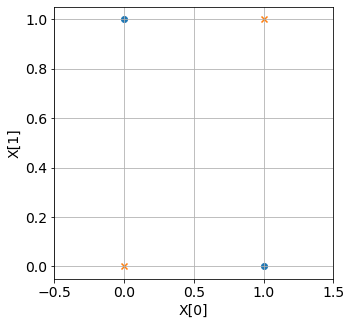

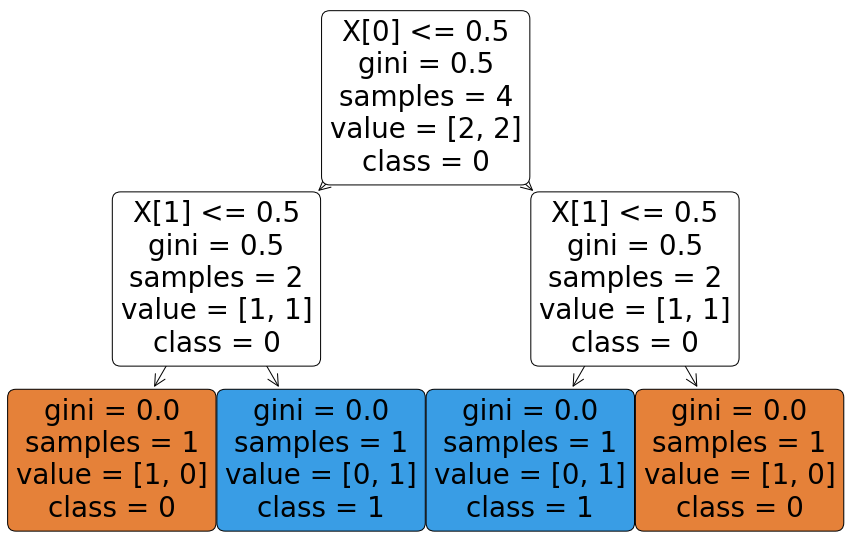

In [26]:
import numpy as np

# Пример решающего дерева на основе задачи XOR
X = np.array([
     [1, 1],
     [1, 0],
     [0, 1],
     [0, 0]
])

y = np.array([
     0,
     1,
     1,
     0
])

plt.figure(figsize=[5,5])
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o')
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
plt.xlim([-0.5, 1.5])
plt.grid()

from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)

plt.figure()
plot_tree(tree, filled=True, rounded=True, impurity=True, class_names=['0', '1'])


На рисунке представлена визуализация обученного дерева решения для нелинейной задачи XOR. Как видно, каждый узел определяет порог признака, так решение сходится до листьев, в котором и определяется конечное решение дерева (предсказанный класс).

Случайный лес работает по принципу набора таких деревьев:

![Замещающий текст](https://miro.medium.com/max/500/1*VHDtVaDPNepRglIAv72BFg.jpeg)

Обучение деревьев происходит на основе алгоритма построения дерева (один из них - [CART](http://pages.stat.wisc.edu/~loh/treeprogs/guide/wires11.pdf)  ~ Classification and regression trees). Построение происходит по принципу поиска наилучших разделений пространства на основе одного из признаков для создания узла и дальнейшего роста.

Одной из важных особенностей случайного леса является то, что для обучения каждое дерево из леса получает не полную выборку, а лишь подвыборку из всей обучающей выборки. Такой принцип назван **Bagging**.

Деревья сами по себе очень чувствительны ко входным данным, так как могут бесконечно создавать узлы по признакам, чтобы максимально точно разделить классы. По факту, дерево очень легко переобучается на тех данных, которые даны для обучения (построения), если не ограничить глубину дерева.

Поэтому при построении каждого малого дерева используется подвыборка, куда могут попадать с повторениями случайные записи из данных со случайными признаками. Таким образом, каждая модель будет видеть лишь часть данных, при этом отдельно каждая слабая модель будет работать плохо, но в совокупности все модели будут давать более точную среднюю оценку в соответсвии с принятием решения по большинству голосов.

In [27]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.8

y_data = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 7) (712,)
(179, 7) (179,)


In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

# Важность признаков

Обучение модели случайного леса позволяет получить оценку важности признаков! Для работы с показателями важности признаков достаточно воспользоваться атрибутом `RandomForestClassifier.feature_importances_`:

Feature: Sex_female | 0.15224129686733381
Feature: Sex_male | 0.14384419737286344
Feature: Embarked_C | 0.011105298934466924
Feature: Embarked_Q | 0.004819245681205841
Feature: Embarked_S | 0.013524060985120172
Feature: Age | 0.2941428805908806
Feature: Fare | 0.3803230195681293


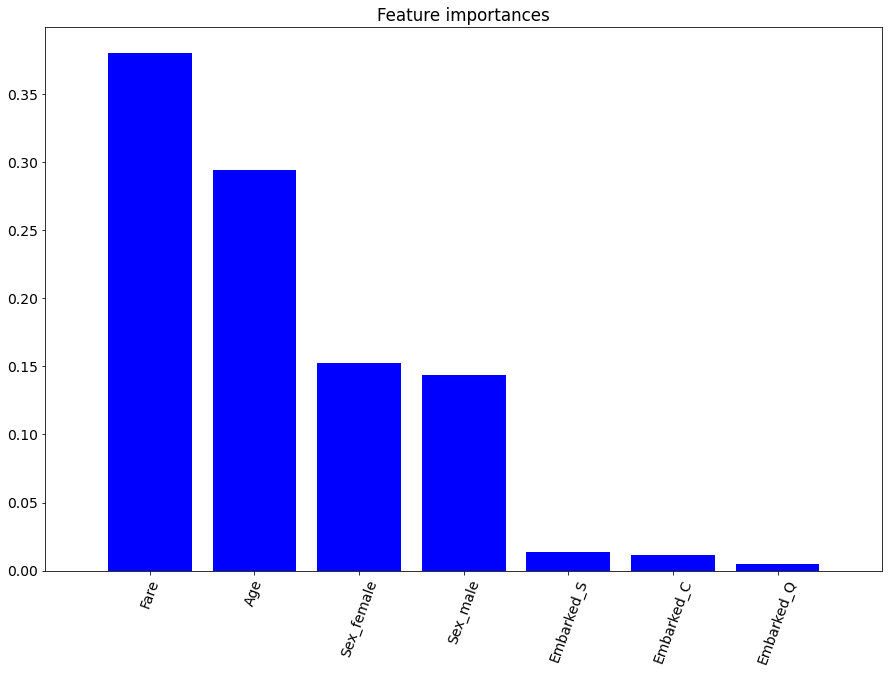

In [29]:
def show_importance(model, feature_names, X):
    importances = model.feature_importances_
    for feat_imp, feat_name in zip(importances, feature_names):
        print(f'Feature: {feat_name} | {feat_imp}')

    indices = np.argsort(importances)[::-1]
    sorted_feat_names = [feature_names[ind] for ind in indices]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X.shape[1]), sorted_feat_names, rotation=70)
    plt.xlim([-1, X.shape[1]])
    plt.show()

show_importance(rf_clf, recovered_feat_names, X_train)

Такой график показывает, как признаки влияли на построение деревьев и насколько каждый из них важен по отношению к другим. 

> **ВАЖНО:** Несмотря на то, что цель графика - показать, насколько важны признаки для предсказания, **нельзя** полагаться лишь на результаты анализа лесом! Часто такая оценка важности смещена. Для более полного анализа в заданиях попробуйте воспользоваться подходом под названием *Feature Elimination*, который более точно позволяет оценить, какие признаки имеют высокое влияние на принимаемое решение модели! Суть подхода в том, что мы постепенно удаляем один за другим признаки из данных и оцениваем, как это повлияло на работу модели.

# Расширенный анализ данных

Результаты построения baseline модели как правило позволяют оценить результаты, которые можно получить наиболее быстрым способом. Дальнейших улучшений можно добиться как настраиванием модели и усложнением алгоритма, так и поиском "инсайтов" в данных, что позволит модели более просто понимать зависимости и принимать правильные решения. Для расширения знаний и подходов предлагаю ознакомиться с [хорошей статьей по EDA](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8), а мы рассмотрим несколько основных способов проанализировать данные и сделать выводы.

### Больше графиков!

Один из самых простых способов проверить пользу признака - анализ нескольких признаков в совокупности, чтобы понять, какие взаимосвязи имеются и дает ли признак информацию. Начнем с того, что постараемся определить, кто чаще выживает - мужчины или женщины:

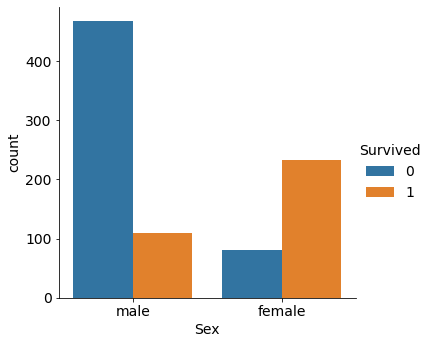

In [30]:
sns.catplot(x="Sex", hue="Survived", kind="count", data=df)

Ответ на графике - выживаемость (Survived = 1) у женского пола больше, что означает необходимость использвания данного признака, так как он влияет на конечное решение! Если бы графики были ровные (все на одном уровне), мы бы не могли по полу человека сказать, кто скорее всего выживет, а значит такой признак бесполезен!

Еще одним интересный признак `Pclass`, класс обслуживания, можно проверить, влияет ли он на выживаемость:

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

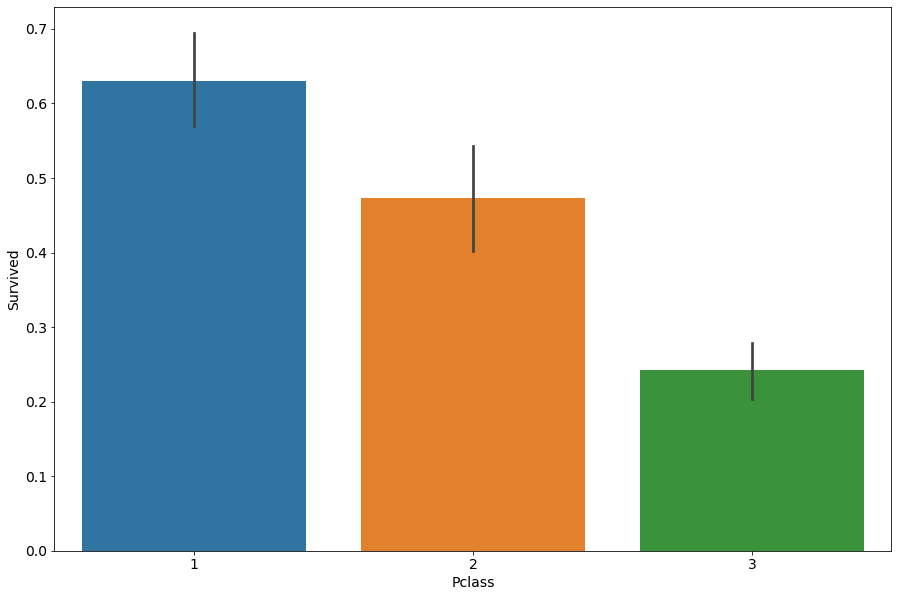

In [31]:
sns.barplot(x='Pclass', y='Survived', data=df)

Как видно, класс тоже вносит свое влияние в выживаемость: обслуживание первого класса более склонно к выживанию.

Также можно влияние признака проверить отображением через `sns.FacetGrid`, чтобы проверить все значения, связанные с несколькими признаками:

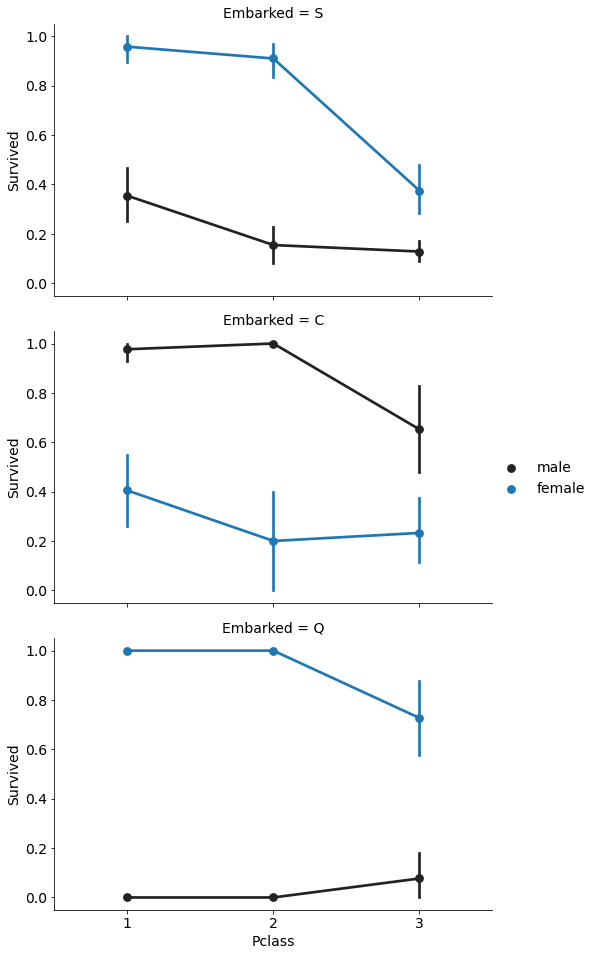

In [32]:
FacetGrid = sns.FacetGrid(df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None)
FacetGrid.add_legend()

Как видно, в зависимости от порта посадки, а одних случаях (порты Q и S) женский пол имеет большие шансы на выживание, чего не скажешь о порте C. Тоже свой вклад в предсказания.

## Создание новых признаков

Помимо исключения признаков одним из широкоприменяемых подходов является создание новых признаков. Для примера, наличие двух признаков `SibSp` и `Parch` сообщает информацию о количестве родственников на борту. Таким образом, можно сформировать дополнительный признак `FamilySize`.

In [33]:
# +1 - we are in family too
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

Новые признаки являются производными от исходных признаков, при этом зависимости не всегда могут являться линейными (например, из даты получить бинарную информацию, является ли день выходным или нет). Такие признаки могут помочь модели найти новые зависимостии и повысить точность.

> Как и ранее с генерацией полиномиальных признаков, можно проводить базовые операции над признаками (унивариативно или над несколькими). С одной стороны, можно делать операции на основе логических допущений - если вы понимаете, что новые признаки точно дадут новую информацию. В другой стороны, можно просто перебирать, пока не найдете такие операции, которые дадут прирост в точности, но это бывает долго и неэффективно.

Для примера после того, как мы создали свой признак "размер семьи", то можно отобразить единый график шансов выживания:

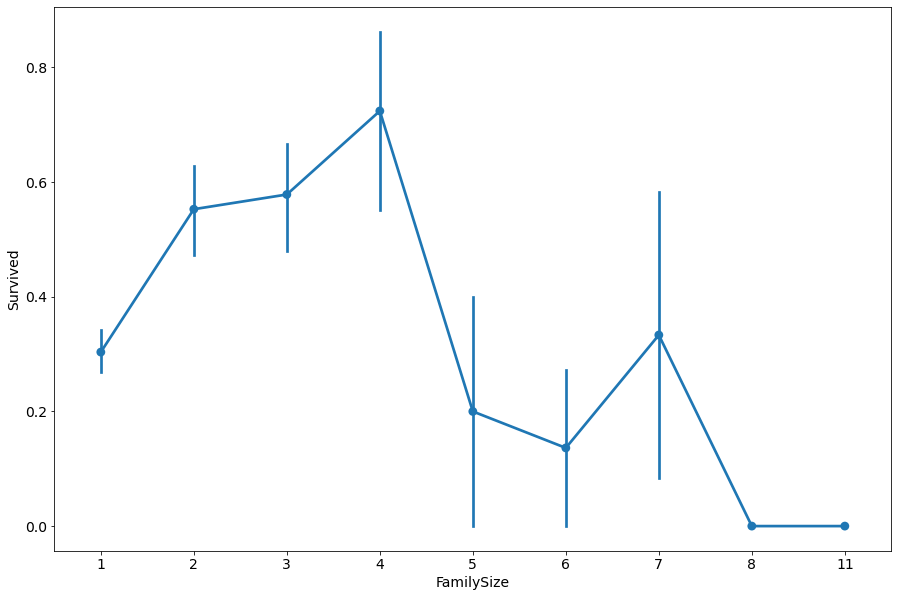

In [34]:
axes = sns.pointplot(x='FamilySize', y='Survived', data=df)

По такому графику можем видеть, что в зависимости от количества членов семьи меняются и шансы на выживание, при этом есть некоторая "критическая точка", что в четыре человека выжить больше шансов, нежели дальнейшее увеличение количества людей в семье на борту.

## Группировка данных (binning)

Одним из способов предобработки данных является группировка численные признаков для формирования категориального признака. Суть подхода в том, чтобы заменить непрерывное значение группами, каждая из которых описывает диапазон значений. Таким образом численное значение заменяется категориальным последовательным.

Такой подход является с одной стороны методом регуляризации, так как модель учится не на точных значениях, а на группах значений. С другой стороны, такой подход теряет часть информации.

Для примера разберем признак `Fare`:

<AxesSubplot:xlabel='Fare'>

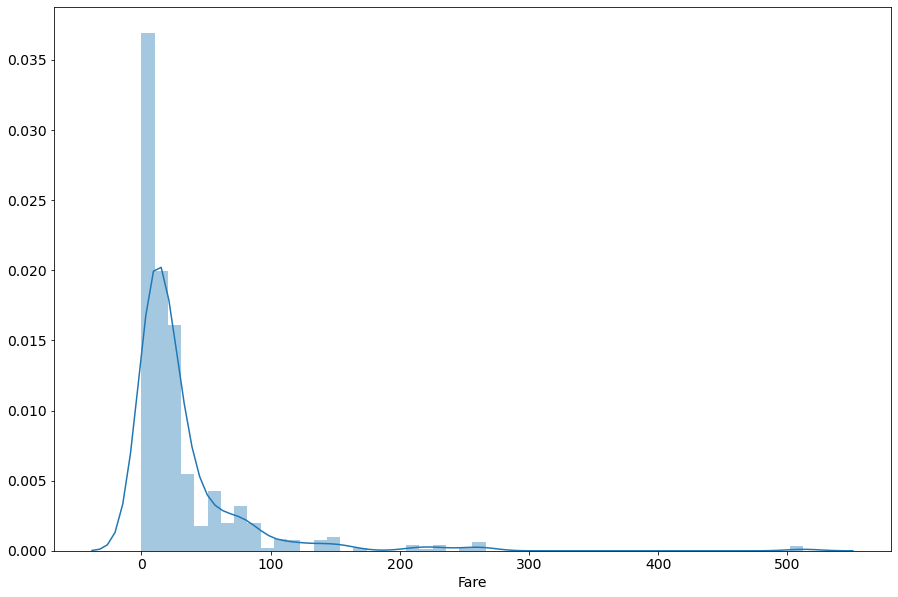

In [35]:
sns.distplot(df['Fare'], bins=50)

Раcпределение немного сдвинуто влево, также слева имеется небольшая мода. Для группировки воспользуется классом `KBinsDiscretizer`, который разделяет весь диапазон на заданное количество групп (бинов).

[array([  0.    ,   7.55  ,   7.8542,   8.05  ,  10.5   ,  14.4542,
        21.6792,  27.    ,  39.6875,  77.9583, 512.3292])]


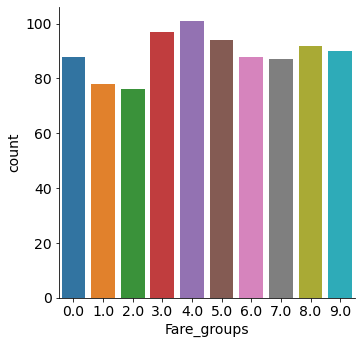

In [36]:
from sklearn.preprocessing import KBinsDiscretizer

discr = KBinsDiscretizer(
    # Количество бинов    
    n_bins=10,
    # Способ кодирования - порядковый
    encode='ordinal',
)

# Двойные скобки для передачи DataFrame (2D данные)
df['Fare_groups'] = discr.fit_transform(df[['Fare']])
# Отобразим границы бинов
print(discr.bin_edges_)

sns.catplot(x='Fare_groups', kind="count", data=df)

Группировка, как видно, привела сильно смещенное влево распределение к равномерному.

Более того, теперь мы можем визуально представить зависимость выживаемости от стоимости билета:

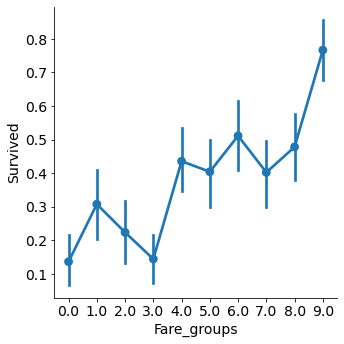

In [37]:
sns.catplot(x='Fare_groups', y='Survived', data=df, kind='point')

или

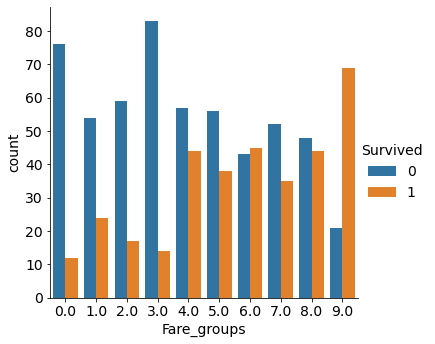

In [38]:
sns.catplot(x='Fare_groups', hue='Survived', data=df, kind='count')

Как видим, сгруппированный признак отображает определенную зависимость выживаемости и стоимости билета. Более высокая стоимость билета имеет больший шанс на выживание.

При этом обратите внимание, что сейчас деление на группы произведено по стратегии равного количества во всех группах. Можно попробовать сделать деление по равным диапазонам групп и сравнить!

# Поиск гиперпараметров

Как известно, многие модели имеют различные параметры, которые влияют на ход построения модели, максимальные и минимальные ограничения в структуре и др. При этом помним, что и сами модели имеют обучаемые параметры (для случая линейной регрессии, например, это веса при признаках). Те параметры, которые не участвуют в предсказании, но определяют архитектуру или другие внешние характеристики модели называют **гиперпараметрами**.

Уже не раз было необходимо произвести поиск и оценку этих гиперпараметров (в KNN - количество соседелей, в Ридж регрессии - $\alpha$). Ручной поиск хорошо справляется, когда имеется опыт и понимание работы модели, но также существуют и автоматизированные методы поиска - одним из них является **GridSearch**.

Основная суть метода в том, что для каждого гиперпараметра задается набор значений, которые требуется попробовать и далее создаётся набор из всех возможных комбинаций заданных гиперпараметров и их значений. Таким образом, исследуемые значения располагаются "как-бы на сетке".

В качестве реализации воспользуемся классом `sklearn.model_selection.GridSearchCV`, который реализует GridSearch с кросс-валидацией.

In [39]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [1, 2, 4, 5, 7],
    'n_estimators': [1, 5, 10, 20, 40],
}

grid_search = GridSearchCV(
    # модель
    estimator=rf_clf,                   
    # сетка параметров
    #   может быть объектом dict 
    #   или list с несколькими dict внутри (несколько сеток)
    param_grid=parameters,              
    # кол-во фолдов для CV
    cv=5,                               
    # метрика для оценки - используем F1 
    scoring='f1_macro',   
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 4, 5, 7],
                         'n_estimators': [1, 5, 10, 20, 40]},
             scoring='f1_macro')

In [40]:
# Для поиска параметров модели внутри пайплайна используется специальное именование:
#   <название шага>__<название параметра>
pipe = Pipeline(steps=[
    ('clf', RandomForestClassifier()),
])

# В названии два подчеркивания!
parameters = {
    'clf__max_depth': [1, 2, 4, 5, 7],
    'clf__n_estimators': [1, 5, 10, 20, 40],
}

grid_search = GridSearchCV(
    # пайплайн
    estimator=pipe,                   
    param_grid=parameters,              
    cv=5,                               
    scoring='f1_macro',   
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
             param_grid={'clf__max_depth': [1, 2, 4, 5, 7],
                         'clf__n_estimators': [1, 5, 10, 20, 40]},
             scoring='f1_macro')

После того, как поиск закончен, можно посмотреть на сетку сгенерированных параметров через аттрибут `cv_results_` и ключ `params`.

In [41]:
grid_search.cv_results_['params']

[{'clf__max_depth': 1, 'clf__n_estimators': 1},
 {'clf__max_depth': 1, 'clf__n_estimators': 5},
 {'clf__max_depth': 1, 'clf__n_estimators': 10},
 {'clf__max_depth': 1, 'clf__n_estimators': 20},
 {'clf__max_depth': 1, 'clf__n_estimators': 40},
 {'clf__max_depth': 2, 'clf__n_estimators': 1},
 {'clf__max_depth': 2, 'clf__n_estimators': 5},
 {'clf__max_depth': 2, 'clf__n_estimators': 10},
 {'clf__max_depth': 2, 'clf__n_estimators': 20},
 {'clf__max_depth': 2, 'clf__n_estimators': 40},
 {'clf__max_depth': 4, 'clf__n_estimators': 1},
 {'clf__max_depth': 4, 'clf__n_estimators': 5},
 {'clf__max_depth': 4, 'clf__n_estimators': 10},
 {'clf__max_depth': 4, 'clf__n_estimators': 20},
 {'clf__max_depth': 4, 'clf__n_estimators': 40},
 {'clf__max_depth': 5, 'clf__n_estimators': 1},
 {'clf__max_depth': 5, 'clf__n_estimators': 5},
 {'clf__max_depth': 5, 'clf__n_estimators': 10},
 {'clf__max_depth': 5, 'clf__n_estimators': 20},
 {'clf__max_depth': 5, 'clf__n_estimators': 40},
 {'clf__max_depth': 7, 'clf_

Для получения наилучших параметров и оценки можно воспользоваться аттрибутами `best_params_` и `best_score_`.

In [42]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__max_depth': 4, 'clf__n_estimators': 40}
0.7924833908496982


Аналогично для `ColumnTransformer`, для учета этапов необходимо использовать `__` для каждой агрегации операций (пайплайн или трансформер колонок). 

# Задачи

- Проведите базовый анализ данных, разделите данные на обучение/тест, разработайте baseline модель решающего дерева [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), оцените работу модели, отобразите важности признаков;
- Разработайте модель линейной регрессии, оцените и сравните с моделью дерева;
- Произведите стандартизацию численных признаков и оцените (сравните) работу моделей с результатами обучения без стандартизации;
- Изучите влияние `max_depth` и `criterion` на показатели дерева, попробуйте 5 разных значений для каждого критерия, оцените с помощью кросс-валидации на обучающей выборке, сделайте таблицу;
- Проведите расширенный анализ данных, выберите наиболее приоритетные для классификации признаки, сравните выбранные признаки с показателями важности признаков, создайте новые признаки; В результате расширенного анализа обратите внимание на следующие особенностями:
    - Проведите создание новых признаков, добавляя каждый новый признак проведите оценку модели:
        - `FamilySize` - размер родственников на корабле;
        - `IsAlone` - является ли пассажир один на корабле или нет (бинарный признак);
        - `FarePerPerson` - оплата билета на человека в семье (воспользоваться `FamilySize`);
        - \*`NameTitle` (если придумаете как) - название титула, сформированое из признака `Name`, редкие титулы стоит объединить в одну группу;
    - Оцените работу модели при добавлении группировки признаков `Age`, `Fare`;
- Обучите модель дерева и модель леса [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) по подготовленным данным;
- Оцените влияние аргументов `max_depth` и `n_estimators` на точность модели (5 значений для каждого) с помощью кросс-валидации на обучающей выборке. Постройте таблицу зависимости метрик от величин;
- Определите наилучшие параметры для модели случайного леса через [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html);
- Определите наилучшие параметры для модели случайного леса через [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html);
- Постройте лучшие модели леса и решающего дерева и сравните их по показателям на выборке для теста.
- Примените подход [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) на лучшую модель случайного леса. Сравните оценку важности признаков RFE и то, что показывает лес.
- Постройте ROC кривые моделей, сравните их и сделайте выводы:
    - лучшая модель на всех признаках;
    - лучшая модель только на топ-7 лучших признаках по RFE;
    - лучшая модель на топ-5 лучших признаках по RFE.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('C:\ml_edu-master\datasets\Titanic_train.csv')
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [44]:
print(data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Первый взгляд на нет пропущенного значения, как видно из приведенного выше рисунка, возраст (Age), кабина(cabin)и встроенный(boarding port) есть пропущенное значение трех столбцов, в которых кабина(cabin) пропущенное значение относительно велико, потому что значение этого столбца само по себе не велико, мы откажемся позже.

In [45]:
print(data.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


Давайте рассмотрим конкретное распределение данных через данные.describe () может видеть, что данные составляют в общей сложности 891 строку, вы также можете видеть максимальные и минимальные значения некоторых столбцов, например возраст этого столбца, самый старый-80 лет, самый маленький-менее одного года.

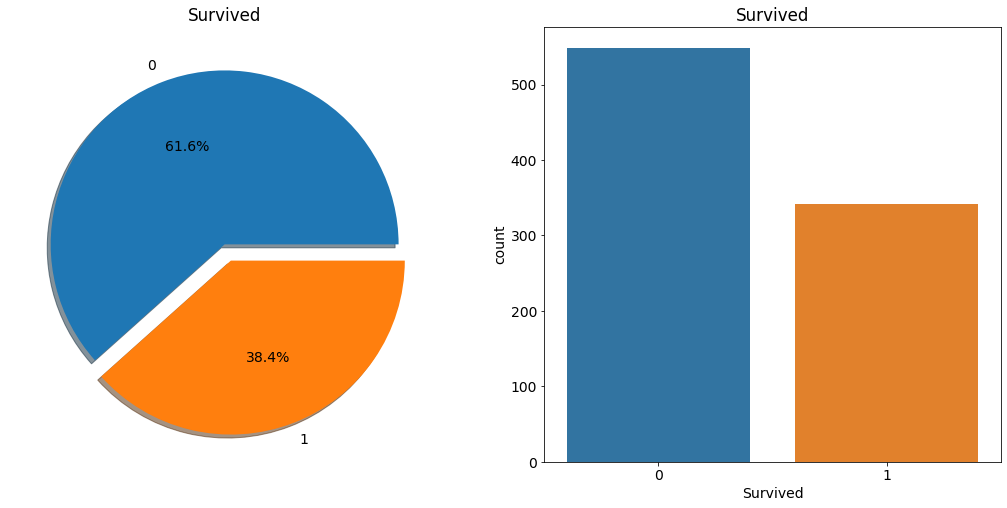

In [46]:
fig,ax = plt.subplots(1,2,figsize=(18,8))
#data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True,ax=ax[0])
ax[0].pie(data['Survived'].value_counts(),explode=[0,0.1],autopct='%1.1f%%',shadow=True,labels=[0,1])
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

Через круговую диаграмму видно, что спасенные составили 38,4%, в общей сложности 891 человек, спасено более 300 человек, что свидетельствует о том, что показатель спасения относительно низок.

1. Анализ гендерных характеристик

In [47]:
print(data.groupby(['Sex','Survived'])['Survived'].count())

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64


Согласно приведенному выше статистическому анализу можно видеть, что вероятность спасения женщин очень велика,мы также можем нарисовать картину, чтобы увидеть.

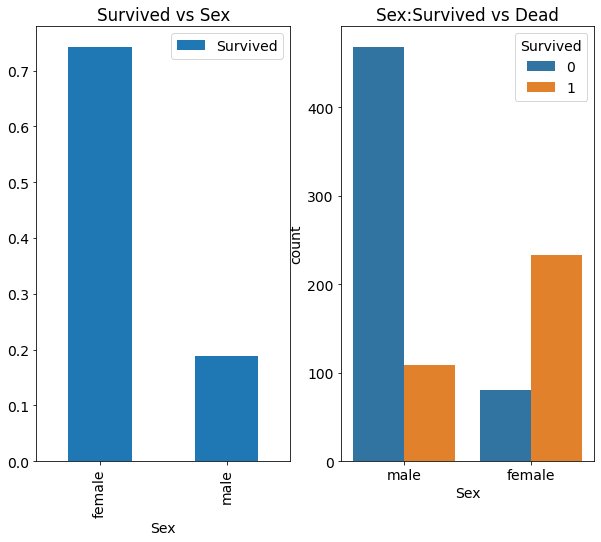

In [48]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax = ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(x='Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

Как видно из левой цифры, если это женщина, то есть более 70% шансов, что все женщины будут спасены, а мужчины только менее 20%, из правой цифры видно, что число спасенных женщин более чем в два раза больше, чем мужчин.В ходе анализа было установлено, что гендер является важным признаком.

2.Анализ характеристик класса кабины

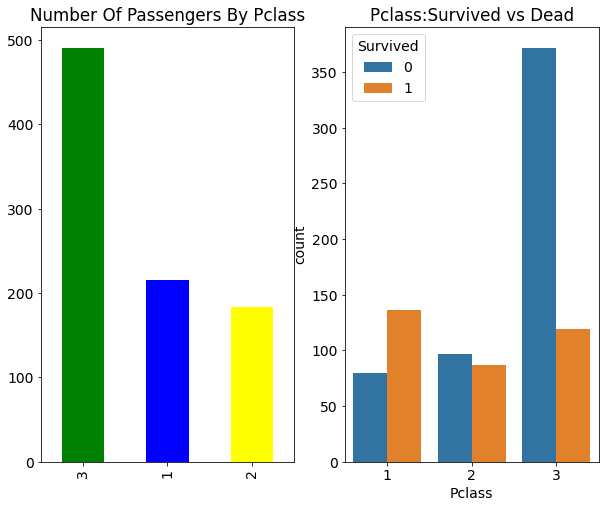

In [49]:
fig,ax=plt.subplots(1,2,figsize=(10,8))
data['Pclass'].value_counts().plot.bar(color=['green','blue','yellow'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
sns.countplot('Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

Количество людей, спасенных в салоне первого класса, больше, чем количество людей, которые не были спасены.Каюта второго класса примерно такая же.Количество людей, спасенных в салоне третьего класса, намного меньше, чем количество людей, которые не были спасены.У богатых по-прежнему гораздо больше шансов спастись, чем у бедных.

Давайте посмотрим на связь между полом и рангом каюты и спасением.

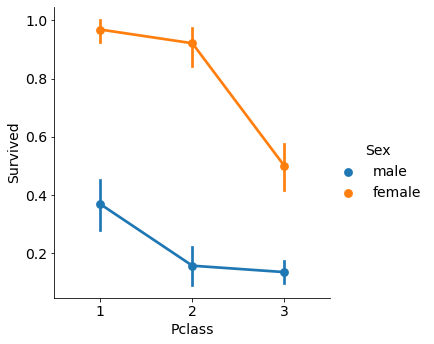

In [50]:
sns.factorplot('Pclass','Survived',hue='Sex',data=data)
plt.show()

Как видно из рисунка выше, доля женщин, спасенных в трех каютах, значительно выше, чем мужчин.

3.Анализ возрастных характеристик

Давайте посмотрим на числовые характеристики возраста.

In [51]:
print('age max',data['Age'].max())
print('age min',data['Age'].min())
print('age mean',data['Age'].mean())

age max 80.0
age min 0.42
age mean 29.69911764705882


Затем нарисуйте и проанализируйте связь между классом кабины и возрастом, полом и возрастом, который нужно сохранить，

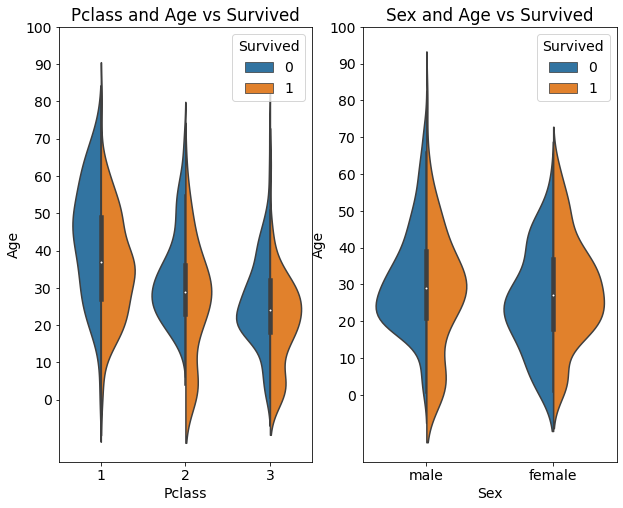

In [52]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
sns.violinplot('Pclass','Age',hue='Survived',data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot('Sex','Age',hue='Survived',data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

Слева вы можете проанализировать, что кабина первого класса была спасена большей частью людей, сосредоточенных примерно в 37,8 лет, кабина второго класса была спасена большей частью людей, сосредоточенных в 30 лет, кабина третьего класса была сосредоточена примерно в 20-30 лет, вы можете видеть, что кабина первого класса была спасена старше, чем две другие кабины.Как видно из правильного рисунка, возраст самца был сохранен примерно в 30 лет, самка была сохранена примерно в 20 ~ 30 лет, разрыв не очень большой.

4.Aнализ особенностей места посадки на борт

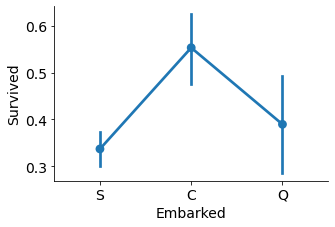

In [53]:
sns.factorplot('Embarked','Survived',data=data)
fig=plt.gcf()
fig.set_size_inches(5,3)

Как видно из приведенного выше рисунка,выживаемость порта С является самой высокой, а Порта S-самой низкой

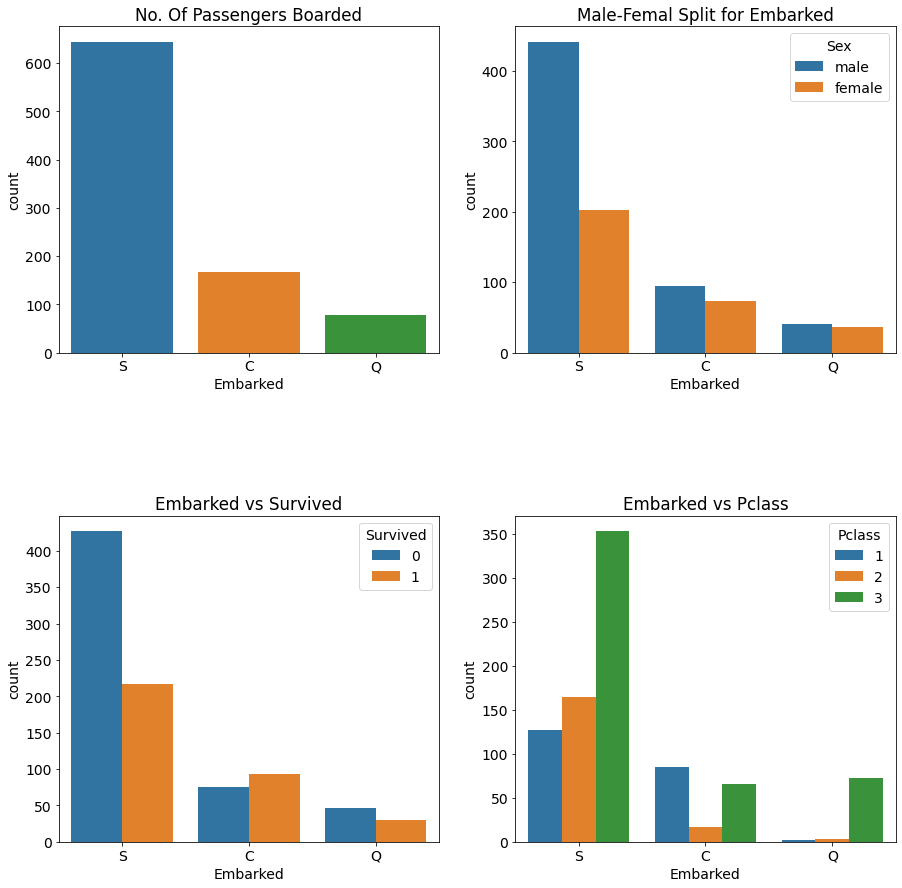

In [54]:
ig,ax=plt.subplots(2,2,figsize=(15,15))
sns.countplot('Embarked',data=data,ax=ax[0][0])
ax[0][0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0][1])
ax[0][1].set_title('Male-Femal Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1][0])
ax[1][0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1][1])
ax[1][1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

Вверху слева статистика количества людей на месте посадки, очевидно, что порт S является самым большим; вверху справа статистика количества мужчин и женщин на каждом месте посадки; внизу слева статистика количества спасенных и неуспешных людей на каждом месте посадки, в сочетании с приведенной выше таблицей, спасенных в порту S. Количество людей самое высокое, но процент спасенных - самый низкий. В правом нижнем углу статистика уровня кают для каждого места посадки показывает, что количество людей, садящихся на борт в порту S, самое большое, а количество людей в третьем классе - самое большое. Почти никто из пассажиров салона первого класса не садился в порт Q.

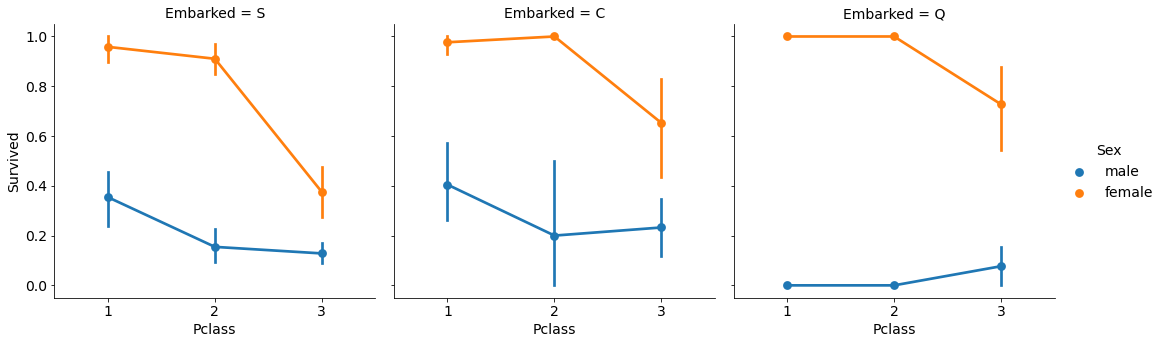

In [55]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

На приведенном выше рисунке показано соотношение мужчин и женщин, спасенных в каждой точке посадки и на каждом уровне каюты. Короче говоря, это полностью соответствует политике, касающейся женщин и детей.

5.Анализ характеристик двоюродного брата / сестры

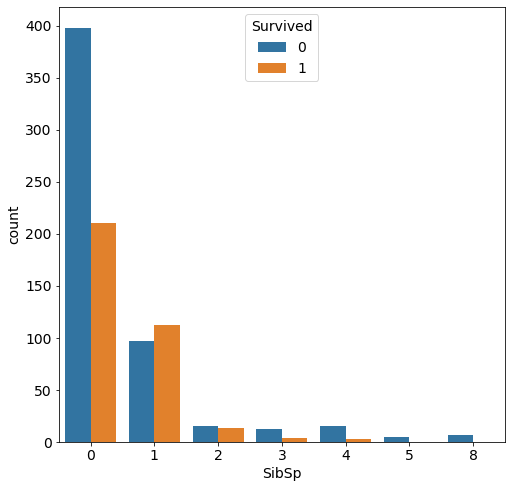

In [56]:
plt.figure(figsize=(8,8))
sns.countplot('SibSp',hue='Survived',data=data)
plt.show()

Из таблицы выше мы видим, что чем больше кузенов / сестер, тем меньше их число и меньше спасенных.

6.Количество родителей и детей характерный анализ

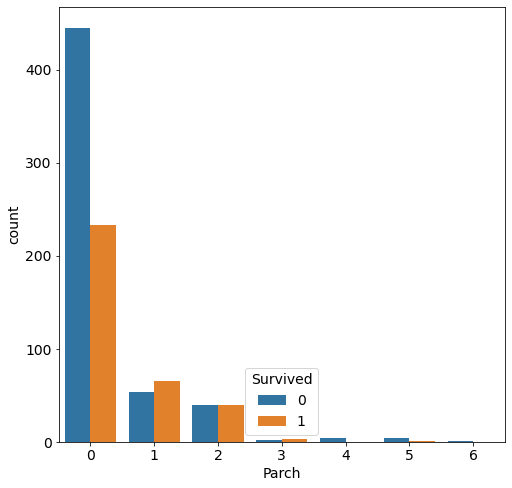

In [57]:
plt.figure(figsize=(8,8))
sns.countplot('Parch',hue='Survived',data=data)
plt.show()

Эта функция аналогична функции количества двоюродных братьев и сестер. Чем больше родителей и детей, тем меньше базовое число и меньше количество спасенных. Например, очень мало людей с 4 или 5 родителями или детьми, и они не спасены.

Очистка и предварительная обработка данных

1.Заполнение недостающего значения
Прежде всего, давайте разберемся с недостающими значениями, используя приведенные выше data.isnull().sum() мы знаем, что отсутствуют два собственных значения (Cabin не рассматривается).

Возрастные проблемы
О заполнении возраста, мы обычно выбираем средний возраст для заполнения, но здесь мы обнаружили, что в названии этой колонки name относительно длинное, середина будет с Mr,Miss,Mrs другими характеристиками, чтобы идентифицировать всех, мы можем в соответствии с этой функцией Найти каждый логотип, средний возраст для заполнения, так что эффект заполнения будет более практичным.

In [58]:
data['initial'] = 0
for i in data:
    data['initial']=data.Name.str.extract('([A-Za-z]+)\.')
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked initial  
0      0         A/5 21171   7.2500   NaN        S      Mr  
1      0          PC 17599  71.2833   C85        C     Mrs  
2      0  STON/O2. 3101282   7.9250   NaN        S    Miss  
3      0            113803  53.1000  C123        S     Mrs  
4      0       

Теперь давайте посмотрим на количество мужчин и женщин.

In [59]:
data['initial']=data['initial'].replace(['Capt','Col','Countess','Don','Dr','Jonkheer','Lady','Major','Master','Mlle','Mme','Ms','Rev','Sir'],'others')
print(data.groupby('initial')['Age'].mean())

initial
Miss      21.773973
Mr        32.368090
Mrs       35.898148
others    20.430161
Name: Age, dtype: float64


Наконец-то мы можем его заполнить.

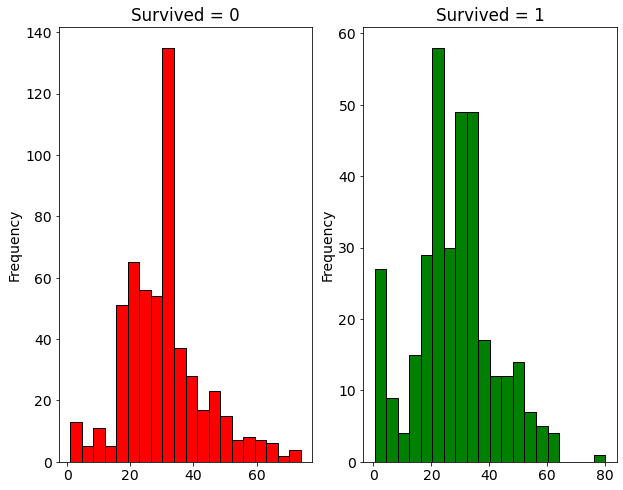

In [60]:
data.loc[(data.Age.isnull())&(data.initial == 'Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.initial == 'Mr'),'Age']=32
data.loc[(data.Age.isnull())&(data.initial == 'Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.initial == 'others'),'Age']=20

fig,ax = plt.subplots(1,2,figsize=(10,8))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived = 0')
data[data['Survived']==1].Age.plot.hist(ax=ax[1],bins=20,edgecolor='black',color='green')
ax[1].set_title('Survived = 1')
plt.show()

Как видно из приведенного выше рисунка, возрастное распределение большинства спасенных людей между 20~40, более 60 лет, чтобы спастись, относительно невелико(самый старый человек (80 лет)был спасен).

Заполнение отсутствующего значения Embarked
Embarked заполнение отсутствующего значения столбца относительно просто,с помощью приведенного выше анализа функций мы можем обнаружить,что наибольшее количество портов S, поэтому мы используем большинство заполнений，

In [61]:
data['Embarked'].fillna('S',inplace=True)
print(data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
initial          0
dtype: int64


2.Предварительная обработка данных
Во-первых, давайте разберемся с бесполезными функциями.

In [62]:
data=data.drop(['Name','Ticket','Cabin','initial'],axis=1)
print(data.head())

   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0            1         0       3    male  22.0      1      0   7.2500        S
1            2         1       1  female  38.0      1      0  71.2833        C
2            3         1       3  female  26.0      0      0   7.9250        S
3            4         1       1  female  35.0      1      0  53.1000        S
4            5         0       3    male  35.0      0      0   8.0500        S


In [63]:
#male=0,female=1
data.loc[data['Sex']=='male','Sex']=0
data.loc[data['Sex']=='female','Sex']=1
#S=0,C=1,Q=2
data.loc[data['Embarked']=='S','Embarked']=0
data.loc[data['Embarked']=='C','Embarked']=1
data.loc[data['Embarked']=='Q','Embarked']=2
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0


Построение модели

1.прогнозирование линейной регрессии

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
linear = LinearRegression()
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
kf=KFold(n_splits=3,shuffle=False,random_state=1)
source_x = data[features] 
source_y = data['Survived'] 
print(source_x.shape)

from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(source_x,source_y,train_size=0.8)
print('A：',source_x.shape,'B：',train_x.shape,'C',test_x.shape)

(891, 7)
A： (891, 7) B： (712, 7) C (179, 7)


In [65]:
linear.fit(train_x,train_y)
print(linear.score(test_x,test_y))

0.3594731588739115


In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
model = LinearRegression()
kf = KFold(n_splits=3,shuffle=False,random_state=1)
scores=[]
for train,test in kf.split(source_x):
    train_data = source_x.iloc[train,:]
    train_target = source_y.iloc[train]
    model.fit(train_data,train_target)
    test_data = model.predict(source_x.iloc[test,:])
    scores.append(test_data)
import numpy as np
scores = np.concatenate(scores,axis=0)
scores[scores>.5]=1
scores[scores<.5]=0
accuracy = sum(scores==source_y)/len(source_y)
print(accuracy)

0.7856341189674523


# Вопросы

- Какой метод оценки модели лучше использовать в данной работе? Разделение на обучение/тест или кросс-валидация? Можно/нужно ли применять их вместе?
- За что отвечают параметры `max_depth` и `n_estimators` в модели случайных лесов? Как они влияют на работу модели?
- В чем отличие GridSearch от RandomSearch?
- Как влияет стандартизация признаков на работу модели леса?
- Что такое "важность признака"? Есть ли аналоги показателя в моделях линейной и логистической регрессии?


1.Какой метод оценки модели лучше использовать в данной работе? Разделение на обучение/тест или кросс-валидация? Можно/нужно ли применять их вместе?
2.За что отвечают параметры max_depth и n_estimators в модели случайных лесов? Как они влияют на работу модели?
Случайный лес Случайный лес - это, по сути, набор множества деревьев решений, которые переобучены разными способами. Мы можем взять среднее значение результатов этих разных деревьев, чтобы уменьшить переобучение, что может уменьшить переобучение и сохранить дерево Умение предсказывать. Случайный лес может использоваться для регрессии или классификации.Он может быть вызван через модуль RandomForestRegressor (регрессия) или модуль RandomForestClassifier (классификация) sklearn.ensemble.
Шаги по построению случайного леса:
①Определите количество деревьев, используемых для строительства
②Самостоятельная выборка данных
③Создать дерево решений на основе нового набора данных
Чтобы построить случайную модель леса, первым делом необходимо определить количество деревьев в лесу и скорректировать его с помощью модели. Чем больше n_estimators, тем лучше, но занимаемая память и время обучения и прогнозирования также соответственно увеличиваются, а предельное преимущество уменьшается, поэтому выбирайте максимально возможные n_estimators в приемлемой памяти / времени. В sklearn значение n_estimators по умолчанию равно 10.
Случайный лес называется случайным лесом, потому что он добавляет случайности при построении. ② и ​​③ - проявления случайности. Второй шаг - это самовыборка данных, то есть случайная выборка из n_sample точек данных с заменой и отрисовка всего n_sample раз. Емкость нового набора данных равна исходному набору данных, но извлеченные образцы часто отличаются от исходного набора данных. Обратите внимание, что набор данных, используемый в построенном дереве n_estimators, является независимым самовыборочным, чтобы гарантировать, что все деревья отличаются друг от друга.
Следующий третий шаг - построить дерево решений на основе этого нового набора данных. Из-за добавления случайности конструкция отличается от общего дерева решений. При построении выберите подмножество функций в каждом узле и найдите лучший тест для одной из функций. Количество функций в выбранном подмножестве функций контролируется параметром max_features. Чем меньше max_features, тем больше различаются деревья в случайном лесу, но слишком маленький (когда 1) приведет к невозможности выбрать, какую функцию тестировать во время разделения. В sklearn max_features имеет следующие методы выбора: «auto», «sqrt», «log2», None. И auto, и sqrt извлекают квадратный корень из общего количества функций, log2 логарифмирует общее количество функций, None делает max_features прямым равным общему количеству функций, а значение max_features по умолчанию - «auto».
Еще один важный параметр случайного леса - n_jobs, который определяет количество используемых ядер ЦП.Использование большего количества ядер может увеличить скорость, а n_jobs = -1 может вызывать все ядра. Конечно, max_depth, min_samples_leaf и max_leaf_nodes также могут использоваться для предварительной обрезки во время строительства, чтобы уменьшить использование памяти и потребление времени.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
	stratify=cancer.target, random_state=4)
forest5 = RandomForestClassifier(n_estimators=5, random_state=0).fit(X_train, y_train)
print("n_estimators=5")
print("Accuracy on training set: {:.3f}".format(forest5.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}\n".format(forest5.score(X_test, y_test)))
forest100 = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
print("n_estimators=100")
print("Accuracy on training set: {:.3f}".format(forest100.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest100.score(X_test, y_test)))

n_estimators=5
Accuracy on training set: 0.998
Accuracy on test set: 0.923
n_estimators=100
Accuracy on training set: 1.000
Accuracy on test set: 0.972

При прогнозировании, если это задача регрессии, прогнозируйте каждое дерево в лесу и принимайте среднее значение результатов в качестве прогнозируемого значения; если это задача классификации, прогнозируйте каждое дерево в лесу, и каждое дерево дает все возможные выходные данные Для каждой метки возьмите среднее значение вероятности, данной каждым деревом, и выберите метку с самой высокой вероятностью в качестве результата предсказания, что называется мягким голосованием.
Случайный лес обладает всеми преимуществами деревьев решений, и значение данного признака более надежно, чем значение, заданное одним деревом. Однако случайные леса плохо работают с разреженными данными с более высокими измерениями, а скорость обучения и прогнозирования ниже, чем у линейных моделей.

3.В чем отличие GridSearch от RandomSearch?
GridSearchCV
Поиск по сетке, поиск параметров, то есть в пределах указанного диапазона параметров, настройка параметров в последовательности в соответствии с длиной шага, использование настроенных параметров для обучения учащегося и поиск наиболее точного параметра в проверочном наборе из всех параметров. Цикл и процесс сравнения. GridSearchCV может гарантировать, что наиболее точные параметры будут найдены в указанном диапазоне параметров, но это также недостаток поиска по сетке. Он требует обхода всех возможных комбинаций параметров, что требует очень много времени в условиях больших наборов данных и нескольких параметров. . Как правило, используется последний метод поиска случайных параметров RandomizedSearchCV.
RandomSearch
Метод использования RandomizedSearchCV фактически такой же, как и GridSearchCV, но он заменяет GridSearchCV поиск параметров по сетке случайной выборкой в ​​пространстве параметров. Для параметров с непрерывными переменными RandomizedSearchCV будет рассматривать его как распределение. Выборка - это то, что не может выполнить поиск по сетке. Его способность поиска зависит от установленного параметра n_iter.

4.Как влияет стандартизация признаков на работу модели леса?
from google.colab import drive
drive.mount('/content/drive')

5.Что такое "важность признака"? Есть ли аналоги показателя в моделях линейной и логистической регрессии?
Важность функции - это метод оценки входных характеристик прогнозной модели, который выявляет относительную важность каждой функции при прогнозировании. Оценки важности функций могут быть рассчитаны для проблем, связанных с прогнозируемыми значениями (называемыми регрессией), и проблем, связанных с прогнозируемыми метками категорий (называемых классификацией).